# Starbucks - Capstone project

<br>
<br>

<img src='images/st02.png' width = 400>

<br>


# Modelling

Along our first script we have explored our data, adapting formats, making it look prettier, and extracting several new features in the process.

This first part was more the _"Data Engineering-like"_ part of the job.

In this second part, we will focus in our models:

# 1) Loading required packages and reading in the files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import datetime as dt

from collections import Counter

from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
# read in the csv files created along our first script:

clean_profile_expanded = pd.read_csv('treated_data/clean_profile_expanded.csv', sep=';', )
total_matched_offers = pd.read_csv('treated_data/total_matched_offers.csv', sep=';')

# 2) Customer segmentation

## 2.1) Customer benchmark

<img src='images/h2.JPG' width=400>

That has been a lot of trouble, but for a reason.

Now we have several features at our disposal in our clean_profile_expanded dataframe.

**GENERAL BENCHMARK:**
    
We will define the current success ratio rate as the following:

* $n_{sc}$ = number of susceptible clients

* $n_{tc}$ = number of total clients

$SR_{clients} = \frac{n_{sc}}{n_{tc}}$

The first benchmark for our model will be:

In [4]:
(clean_profile_expanded['score'] == 1).sum()/clean_profile_expanded.shape[0]

0.5319392917369309

So, at this moment, the massive emailing campaign is getting to the right clients with a probability of about 53,2%.

## 2.2) Normalization and feature engineering

 ### 2.2.1) Feature analysis

We could see above a glance of the different success rates the offers have on the customers.

At this point, we want to remember that we decided to divide our users in highly succeptible to our offers, somewhat curious and those not at all interested:

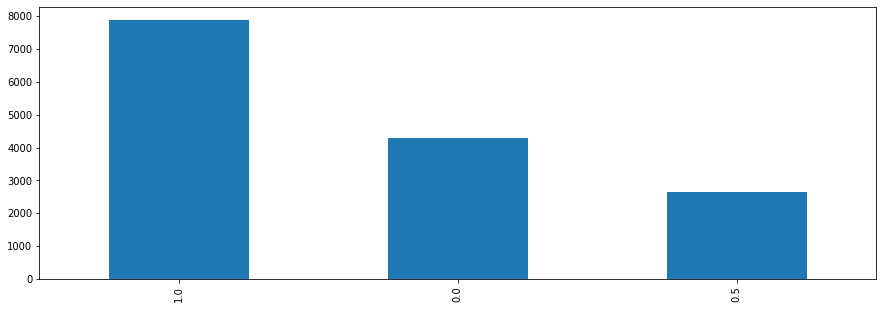

In [5]:
clean_profile_expanded['score'].value_counts().plot('bar');

We can see that, in general, our customer base responds well to our offers.

Also, the ammount of people we cannot decide whether are interested or not, does not constitute a big group.

Now, we are going to check the correlation of the rest of our variables with our target variable.

But, before, there are some characteristics that are not properly treated: indeed, sex, or group age have not been numerically defined, so there will be no information on their correlations, although we have seen in our exploration that these variables have an inpact on our target variable (the offer acceptance rate):

In [6]:
pos = len(clean_profile_expanded.columns) - 1

for col in ['gender', 'age_group']:
    col_dict = dict(clean_profile_expanded.groupby(col)['score'].mean())
    clean_profile_expanded.insert(pos, col+'_n', clean_profile_expanded[col].apply(lambda x: col_dict[x]))

age                    0.134886
income                 0.293226
year_bmo              -0.244421
month_bmo              0.031364
day_bmo               -0.004198
seniority              0.247225
tot_offers_received    0.037260
tot_am_spent           0.513247
mean_resp_t           -0.660342
max_resp_t            -0.632907
min_resp_t            -0.675990
nbr_pur                0.343184
tot_am_offers          0.399995
pur_interval          -0.257820
age_group_n            0.150874
gender_n               0.213288
score                  1.000000
Name: score, dtype: float64

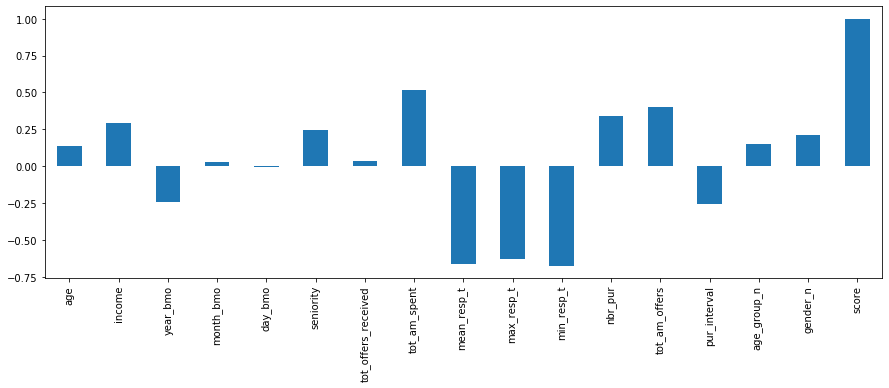

In [7]:
clean_profile_expanded.corr()['score'].plot('bar')
clean_profile_expanded.corr()['score']

We can see that we have several strong correlations, both positive and negative.

Now, let's put face to these correlations:

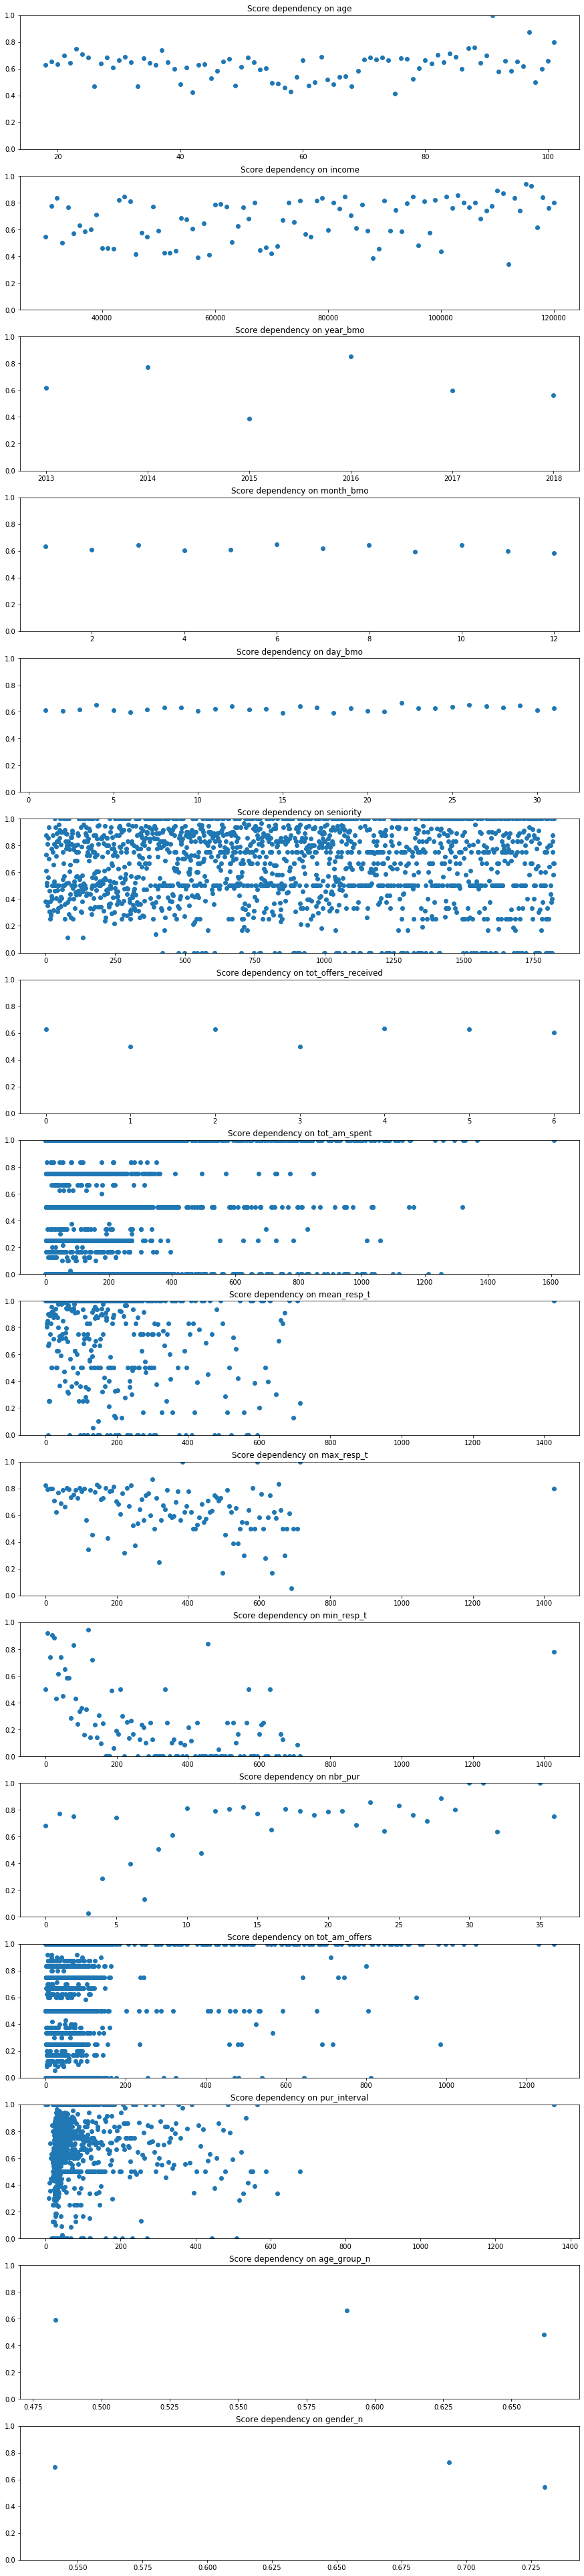

In [8]:
num_cols_list = list(clean_profile_expanded.corr()['score'].index)

num_cols_list.remove('score')

fig, ax = plt.subplots(len(num_cols_list), figsize = (15,70))



for i, col in enumerate(num_cols_list):
    
    x_vals = clean_profile_expanded[col].unique()
    y_vals = np.array(clean_profile_expanded.groupby(col)['score'].mean()).reshape(1, -1)
    
    ax[i].title.set_text('Score dependency on {}'.format(col))
    ax[i].set_ylim([0, 1])
    ax[i].scatter(x_vals, y_vals)

But also, we suspect many of our variables are intercorrelated. Particularly, the max, min and mean times of response to an offer should be heavily correlated among themselves.

Let's check it out:

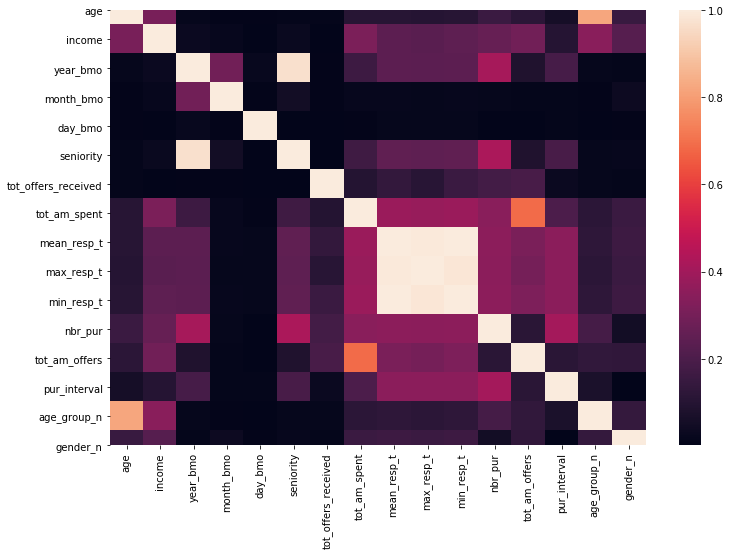

In [9]:
cust_feat_list = list(clean_profile_expanded.columns)
cust_feat_list.remove('score')

figure1 = plt.figure(figsize = (12,8))
cust_corr_matrix_df = clean_profile_expanded[cust_feat_list].corr()
sns.heatmap(cust_corr_matrix_df.abs())

We can see that we guessed correctly about the max, min and mean response times.

But we have also several other high correlations. We are going now to take a closer look, by signaling those correlations that trespass some threshold:

In [10]:
threshold = 0.4
cust_corr_matrix_df.apply(lambda x: list(set(x[x>threshold].index) - set([x.name])))                       

age                                [age_group_n]
income                                        []
year_bmo                                      []
month_bmo                                     []
day_bmo                                       []
seniority                              [nbr_pur]
tot_offers_received                           []
tot_am_spent                     [tot_am_offers]
mean_resp_t             [max_resp_t, min_resp_t]
max_resp_t             [mean_resp_t, min_resp_t]
min_resp_t             [mean_resp_t, max_resp_t]
nbr_pur                              [seniority]
tot_am_offers                     [tot_am_spent]
pur_interval                                  []
age_group_n                                [age]
gender_n                                      []
dtype: object

Appart from those stated above, we have also high correlations between:

**age - age_group_n**

We were expecting this one. Even when the relationship between these two values is not direct, the second is in some way derived from the first (we have grouped people by age and deducted their behavior from those groups).

We will drop the later.
    
**seniority - nbr_pur**

Seems reasonable that a certain correlation exists between the number of years a client has been registered, and the number of purchases the same client has performed. But both variables doesn't share a common origin that could lead us to suspect, both are derived from the same information. We will keep both.

**tot_am_spent - tot_am_offers**

These variables represent the money a client has spent in general, and the ammount the same client has spent on offers. As before, a certain level of correlation is expected but again, these two pieces of information don't share a common origin.

But, perhaps for this case, the substitution of one of the variables (or both) for some combination might be more insightful.
We will try:

*non_offers_spent* = *tot_am_spent* - *tot_am_offers*

*offers_spend_share* = *tot_am_offers* / *tot_am_spent*

,tot_am_spent,tot_am_offers,non_offers_spent,offers_spend_share,score
tot_am_spent,1.000000,0.690424,0.866389,0.115802,0.513247
tot_am_offers,0.690424,1.000000,0.236928,0.443865,0.399995
non_offers_spent,0.866389,0.236928,1.000000,-0.152100,0.413167
offers_spend_share,0.115802,0.443865,-0.152100,1.000000,0.415306
score,0.513247,0.399995,0.413167,0.415306,1.000000


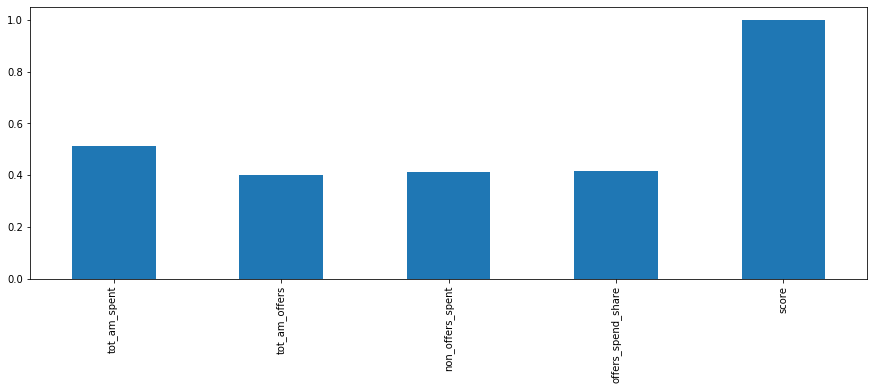

In [11]:
# Creating the new variables:

pos = len(clean_profile_expanded.columns) - 1

clean_profile_expanded.insert(pos,
                              'non_offers_spent', 
                              clean_profile_expanded['tot_am_spent'] - clean_profile_expanded['tot_am_offers'])


clean_profile_expanded.insert(pos + 1,
                              'offers_spend_share', 
                              clean_profile_expanded['tot_am_offers'] / clean_profile_expanded['tot_am_spent'])


# Checking the correlations:

corr_cols = ['tot_am_spent', 'tot_am_offers', 'non_offers_spent', 'offers_spend_share', 'score']

correlations = clean_profile_expanded[corr_cols].corr()

correlations['score'].plot('bar')
correlations

So, we decide to drop the columns as stated above, plus: *tot_am_spent* and *offers_spend_share*, because of their combination of correlation to our target variable, and interdependence.

So, at end the columns we will drop are:

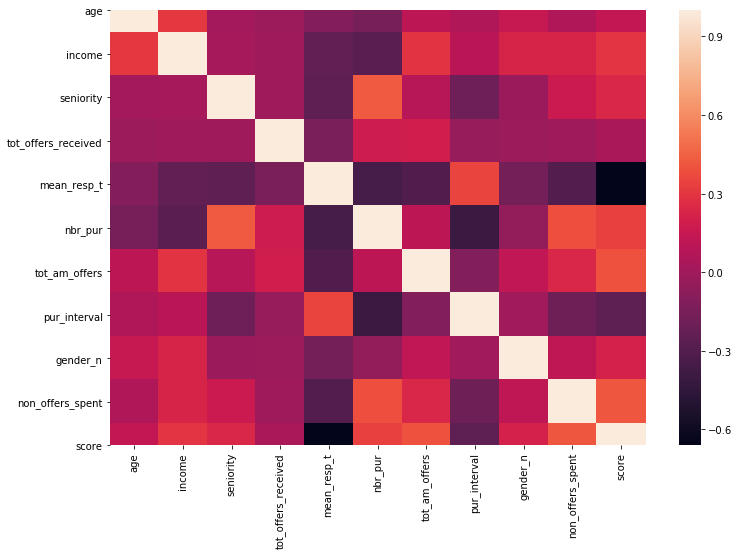

In [12]:
# Columns to be dropped:
dr_cols = ['gender', 
           'date_bmo', 
           'year_bmo', 
           'month_bmo', 
           'day_bmo',
           'age_group',
           'min_resp_t', 
           'max_resp_t', 
           'tot_am_spent', 
           'offers_spend_share',
           'age_group_n']

clean_profile_for_mod = clean_profile_expanded.drop(dr_cols, axis=1)

# And the resulting correlation plot:
figure2 = plt.figure(figsize = (12,8))
sns.heatmap(clean_profile_for_mod.corr())

Now, after the cleanse, we have:

In [13]:
threshold = 0.4
clean_profile_for_mod.corr().apply(lambda x: list(set(x[x>threshold].index) - set([x.name])))

age                                    []
income                                 []
seniority                       [nbr_pur]
tot_offers_received                    []
mean_resp_t                            []
nbr_pur                       [seniority]
tot_am_offers                          []
pur_interval                           []
gender_n                               []
non_offers_spent                  [score]
score                  [non_offers_spent]
dtype: object

### 2.2.2) Normalization

We will now proceed to normalize our data, as we can see it is still non normalized:

In [14]:
clean_profile_for_mod.head()

,age,id,income,seniority,tot_offers_received,mean_resp_t,nbr_pur,tot_am_offers,pur_interval,gender_n,non_offers_spent,score
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376,1.0,120.0,3.0,23.22,255.0,0.730299,53.79,0.5
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,3.0,80.0,7.0,41.61,67.0,0.730299,117.66,1.0
2,68,e2127556f4f64592b11af22de27a7932,70000.0,91,3.0,66.0,3.0,18.42,117.0,0.541136,39.31,1.0
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,167,6.0,134.4,3.0,36.43,270.0,0.541136,0.00,1.0
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,2.0,120.0,4.0,7.14,118.0,0.541136,8.48,0.5


We will use _MinMaxScaler_, which will make the following transformation:
    
$\frac{x-x_{min}}{x_{max}-x_{min}}$

In [15]:
aux = clean_profile_for_mod.drop('id', axis=1)
# aux['inv_mrt'] = aux['mean_resp_t'].apply(lambda x: 1/x if x!=0 else 1)
# aux['inv_tao'] = aux['tot_am_offers'].apply(lambda x: 1/x if x!=0 else 1)
# aux['inv_pur_int'] = aux['pur_interval'].apply(lambda x: 1/x if x!=0 else 1)

scaled_xy = pd.DataFrame(MinMaxScaler().fit(aux).transform(aux), columns = aux.columns)

scaled_x = scaled_xy.drop('score', axis=1)
y = scaled_xy['score']

### 2.2.3) PCA Analysis

Now, we will perform a PCA analysis, to see if we can reduce the dimensionality of our problem, and use a more convenient combination of our variables, in advantage fokr our models.

But first, let's plot our correlations between our normalized features and our target variable:

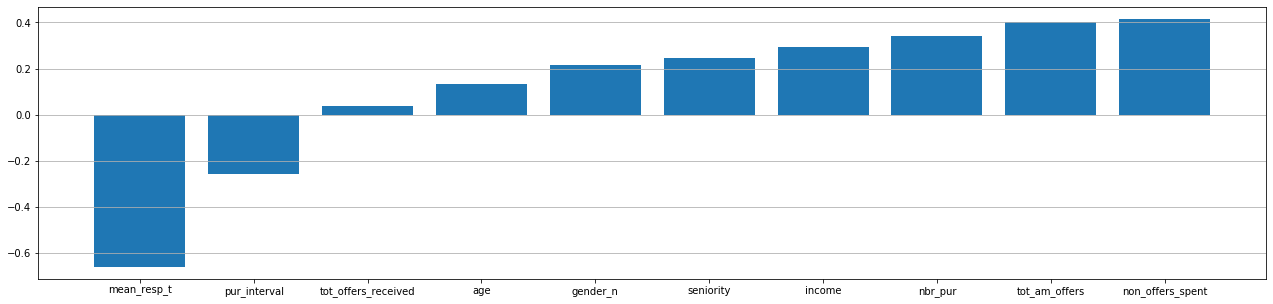

In [16]:
corr_series= pd.Series([])
for col in scaled_x:
    correl = np.corrcoef(clean_profile_for_mod['score'], scaled_x[col])[0][1]
    corr_series[col] = correl

fig_n = plt.figure(figsize=(22,5))
plt.bar(corr_series.sort_values().index, corr_series.sort_values())
plt.grid(axis='y')

And now, let's perform a PCA analyisis, performing the linear transformation and examining the weight of each component in the transformed space:

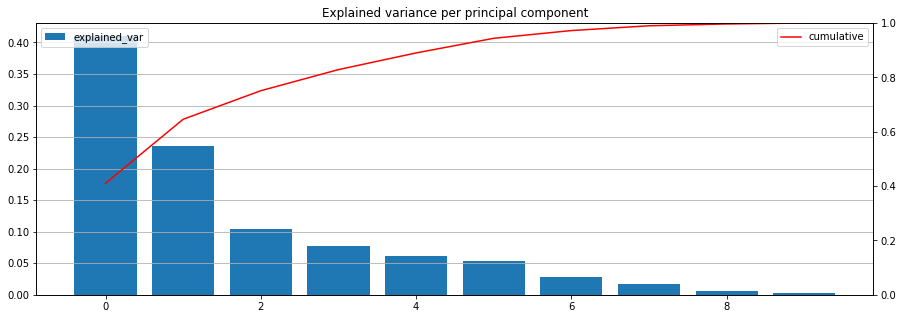

In [17]:
pca_mod = PCA()
pca_mod = pca_mod.fit(scaled_x)

exp_var_ratio = pca_mod.explained_variance_ratio_
components = range(len(exp_var_ratio))

plt.title('Explained variance per principal component')
plt.bar(components, exp_var_ratio, label = 'explained_var')
plt.grid(axis='y')
plt.legend(loc=2)

ax2=plt.twinx()
ax2.set_ylim([0, 1])
plt.plot(components, np.cumsum(exp_var_ratio), 'r', label = 'cumulative')
plt.legend(loc=1)

We can see that our first variable explains more of the 40% of the variance in our features space.

Also, the second variable explains an additional 24%, and with the third component (10%) we would have about 75% of our feature's variance under control.

Let's take a closer look to those component's composition in terms of our features:

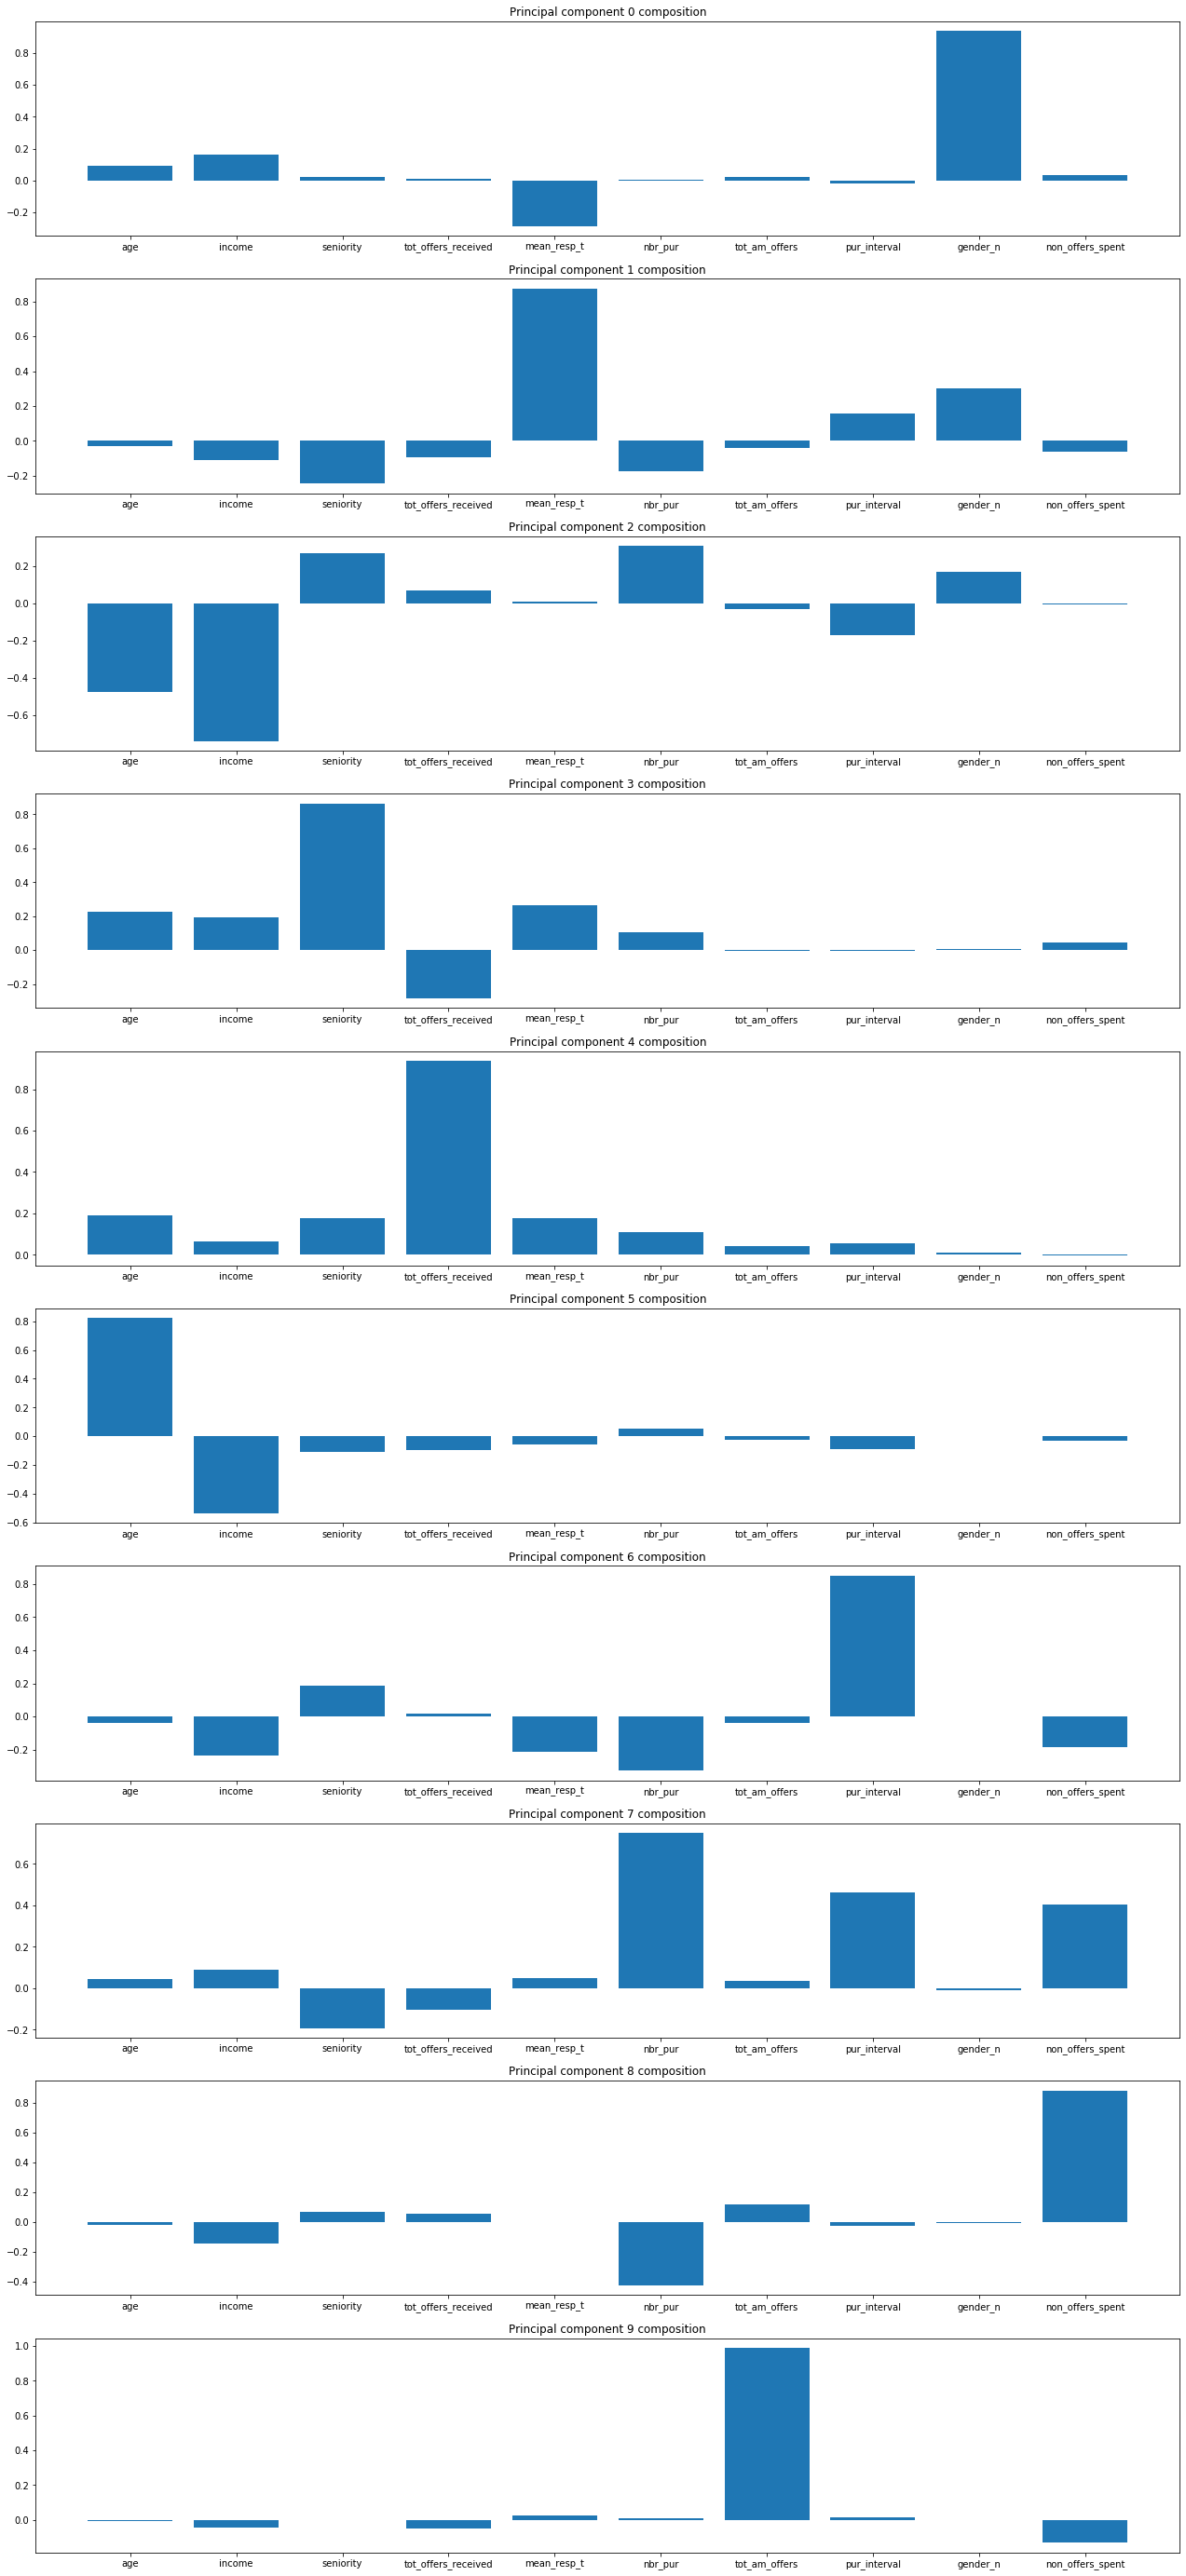

In [18]:
n = 10
fig2, ax = plt.subplots(n, figsize = (22,5*n))

for i in range(0,n):
    ax[i].title.set_text('Principal component {} composition'.format(i))
    ax[i].bar(scaled_x.columns, pca_mod.components_[i])

We can see that this base does not differ much from our original. 

Appart from some interrelation between age and income, found in two of the principal components of the transformed space, for the rest there is always a strong relationship with one of ou original features, and weak relationships with the rest.

This means that our new base is almost identical to our features base.

Also, some of the least autoexplanatory variables (e.g.: *tot_am_offers*) are those that explain the most our target variable.

This means we cannot drop those columns, and then, is not that we cannot reduce the dimensionality of our problem, but that performing a PCA decomposition yields little to no gain from our original situation.

For these reasons, we will not perform such decomposition.

## 2.3) Customer clustering and benchmark models

Now, before going for other models, we want to use two unsupervised clustering algorithms to divide our customer base, and we will see if the resulting clusters give us some insights that might be useful.

We will use DBSCAN and K-Means:

### 2.3.1) DBSCAN

DBSCAN is a density-based algorithm.

The main hyperparameter is the minimum number of samples each cluster shall contain.

As the number of resulting clusters is a more intuitive measure, we will define a list of minima and try out all of them, to see the resulting number of clusters:

In [19]:
for i in [10, 20, 50, 100, 150, 200, 500, 1000]:

    dbscan_model = DBSCAN(min_samples = i)

    fitted_dbscan_model = dbscan_model.fit(scaled_x)
    groups = np.unique(fitted_dbscan_model.labels_)
    print(i, groups)

10 [-1  0  1  2  3  4  5]
20 [-1  0  1  2  3  4  5]
50 [-1  0  1  2  3  4  5]
100 [-1  0  1  2  3  4  5]
150 [-1  0  1  2  3  4]
200 [-1  0  1  2  3]
500 [-1  0  1  2]
1000 [-1  0  1  2]


We will keep 200 as the min_samples, for a total 4 clusters, and a fifth of 'unclassifiable' (-1):

In [20]:
dbscan_model = DBSCAN(min_samples = 200)
fitted_dbscan_model = dbscan_model.fit(scaled_x)

Let's see how many elements each cluster has:

In [21]:
Counter(fitted_dbscan_model.labels_)

Counter({0: 5555, 1: 6400, 2: 598, 3: 1873, -1: 399})

And now, we want to append its cluster to each element of our dataframe and group by cluster, to extract some insight:

In [22]:
clean_profile_for_mod = clean_profile_for_mod.copy()
clean_profile_for_mod['dbscan_group'] = fitted_dbscan_model.labels_
clean_profile_for_mod.groupby('dbscan_group').mean()

,age,income,seniority,tot_offers_received,mean_resp_t,nbr_pur,tot_am_offers,pur_interval,gender_n,non_offers_spent,score
dbscan_group,,,,,,,,,,,
-1,58.385965,74142.857143,365.889724,3.541353,1321.803759,1.626566,32.979148,1145.162911,0.629525,65.947268,0.110276
0,57.788839,72347.434743,541.023582,3.632223,74.373159,8.637444,56.452868,87.852013,0.729109,97.243795,0.820612
1,52.970937,63771.406250,597.839219,3.709062,86.909375,9.726719,43.687717,81.739035,0.541136,79.040758,0.699219
2,53.357860,56929.765886,269.177258,3.036789,1428.000000,4.591973,0.000000,115.945187,0.728756,27.434080,0.073579
3,48.664709,51241.324079,324.205019,3.233849,1428.000000,5.515216,0.000000,115.640001,0.541136,21.258932,0.049386


We can see that:

We find clearly defined differences in clusters in the following variables:
    
- mean_resp_t

- nbr_pur

- tot_am_offers

- non_offers_spent

And clearly defined differences in the following variables:
    
- age

- seniority

- gender_n


And slight differences in the following variables:
    
- age

Also, and more importantly, there is a *CLEAR PATTERN* in our target variable:

Clusters 0 and 1: clients highly susceptible to our offers
Cluster 2 and 3 (and -1): no-go for offers

So, this means that, in regards of our target variable, our clusters are useful, and that we can use them to create a simple model:

In [23]:
def dbmeans_scoring_fun(x):
    if x in [0,1]:
        return 1
    else:
        return 0
    
def assesing_function(fun, series, y):
    
    y_hat = series.apply(fun)
    
    if (y==0.5).any():
        y = 2*y
        y_hat = 2*y_hat
        
    cm = confusion_matrix(2*y, 2*y_hat)
    norm_cm = cm/cm.sum()
    acc = np.matrix.trace(norm_cm)

    print(norm_cm)
    print(acc)
    
    return cm, norm_cm, acc

dbmeans_cm, dbmeans_norm_cm, dbmeans_acc = assesing_function(dbmeans_scoring_fun, 
                                                             clean_profile_for_mod['dbscan_group'], 
                                                             y)

[[0.17112985 0.         0.11777403]
 [0.02057336 0.         0.15858347]
 [0.0018887  0.         0.53005059]]
0.7011804384485666


We can see that this model yields a 70% accuracy. 

This is much better than our defined benchmark.

This accuracy is considering all the data, including also the clients marked with 0.5, considered "dubious", and that were to be left out of our models.

In fact, if we dropped those clients, our results would be:

In [24]:
def to_binary(norm_cm):
    bi_norm_cm = norm_cm[[0,2]]/norm_cm[[0,2]].sum()
    bi_acc = bi_norm_cm[0][0] + bi_norm_cm[1][2]
    
    print(bi_norm_cm)
    print(bi_acc)
    
    return bi_norm_cm, bi_acc

In [25]:
_ = to_binary(dbmeans_norm_cm)

[[0.20848057 0.         0.14347933]
 [0.00230093 0.         0.64573917]]
0.854219738680253


We can see that, for the _"binary case"_ (only two labels, as a result of droping those marked with 0.5) our accuracy improves dramatically, to about 85,4%.

### 2.3.2) K-Means

Let's try out now the Kmeans. We will use the same number of clusters as in the DBSCAN case, and add the resulting clusted also to our original dataframe, and group, and extract some insight:

In [26]:
kmeans_model = KMeans(4)
fitted_kmeans_model = kmeans_model.fit(scaled_x)

In [27]:
clean_profile_for_mod['kmeans_group'] = fitted_kmeans_model.labels_
clean_profile_for_mod.groupby('kmeans_group').mean()

,age,income,seniority,tot_offers_received,mean_resp_t,nbr_pur,tot_am_offers,pur_interval,gender_n,non_offers_spent,score,dbscan_group
kmeans_group,,,,,,,,,,,,
0,57.806069,72438.678398,541.232178,3.632968,74.299623,8.635123,57.606247,87.873454,0.729112,98.589348,0.821063,-0.002693
1,53.015126,63851.551536,598.348823,3.710276,86.498986,9.728052,44.521293,81.684635,0.541136,80.846582,0.700140,0.995010
2,54.797927,60936.528497,303.484456,3.117876,1426.997409,3.981865,0.012539,345.789275,0.728721,26.151023,0.065415,1.325130
3,49.334621,52967.165620,318.748431,3.267986,1426.951231,5.025592,0.010541,228.796017,0.541136,19.741598,0.048769,2.620473


We can see that:
    
**1) Again, we can see patterns in our feature behavior, in function of the cluster:**
    
We find clearly defined differences in clusters in the following variables:
    
- mean_resp_t

- nbr_pur

- tot_am_offers

- non_offers_spent

And clearly defined differences in the following variables:
    
- age

- seniority

- gender_n


And slight differences in the following variables:
    
- age

**2) Also: we can see that the clusters coincide with those resulting from the DBSCAN**

As shows their average value, when grouped by the clusters resulting from the K-Means. This is especially true for our clusters of customers that are highly susceptible to our offers, and a little bit less, for the other two clusters.

In [28]:
grouped_df = clean_profile_for_mod.groupby('kmeans_group')['score'].mean()
listed_vals = list(grouped_df[grouped_df>0.5].index)

Now, we can do the same assignation as we did with the DBSCAN, and check the accuracy of this method.

As the clusters are very similar to each other, we should expect similar results to the previous case:

In [29]:
def kmeans_scoring_fun(x):
    if x in listed_vals:
        return 1
    else:
        return 0

kmeans_cm, kmeans_norm_cm, kmeans_acc = assesing_function(kmeans_scoring_fun, 
                                                          clean_profile_for_mod['kmeans_group'], 
                                                          y)

[[0.17133221 0.         0.11757167]
 [0.02043845 0.         0.15871838]
 [0.         0.         0.53193929]]
0.7032715008431704


In [30]:
_ = to_binary(kmeans_norm_cm)

[[0.20872709 0.         0.1432328 ]
 [0.         0.         0.6480401 ]]
0.8567671953324021


Now, let's see whether it is possible to increase the accuracy of our methods by increasing the number of asociated clusters, or if our intuition was right, and we were using around the right number of clusters.

For this, we will use the elbow method:

In [31]:
elbow_m_results = pd.Series([])

for i in range(1,21):
    kmeans_model = KMeans(i)
    fitted_kmeans_model = kmeans_model.fit(scaled_x)
    elbow_m_results[i] = fitted_kmeans_model.inertia_

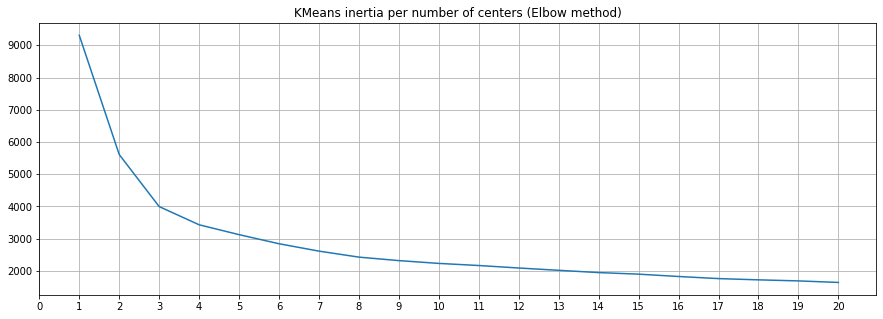

In [32]:
vals = list(range(21))

plt.title('KMeans inertia per number of centers (Elbow method)')
plt.plot(elbow_m_results)
plt.xticks(vals)
plt.grid()

We can see that we are clearly in the elbow region.

From this point on, few more information can be extracted from the variables by grouping them in smaller regions, as those regions will be closer to each other, and share traits.

This means that we have extracted all the information we could from these clustering algorithms.

One last insight: as these methods have taught us, we have some features that clearly distinguish those two clusters containing our customers susceptible to our offers, from those who contain those who are not.

These variables are the following:

In [33]:
imp_feats_list = ['seniority', 'mean_resp_t', 'nbr_pur', 'tot_am_offers', 'pur_interval', 'gender_n', 'non_offers_spent']

If necesary, we can reduce the dimensionality of our problem by keeping these variables, that it has been shown that have a clear  impact on our target characterization.

## 2.3) Customer segmentation benchmark model

We divide our normalized dataframe in train and test, for trying out our models.

We are going to define two sets of train and test data, one keeping the dubious clients, and the other without them.

We will do this because we want to see if keeping our clients can help in the training of our models, which may yield a gain in terms of final accuracy (always, as we did with the previous clustering models, considering the binary case without dubious clients).

In [34]:
# red_scaled_xy = scaled_xy[imp_feats_list]
# bi_scaled_xy = red_scaled_xy.loc[y[y!=0.5].index, :]

In [35]:
filtered_xy = scaled_xy[scaled_xy['score']!=0.5]
filtered_xy_train, filtered_xy_test = train_test_split(filtered_xy, random_state=37, train_size=0.7)

bi_x_train = filtered_xy_train.drop('score', axis = 1)
bi_y_train = filtered_xy_train['score']

bi_x_test = filtered_xy_test.drop('score', axis = 1)
bi_y_test = filtered_xy_test['score']

In [36]:
xy_train, xy_test = train_test_split(scaled_xy, random_state=37, train_size=0.7)

tri_x_train = xy_train.drop('score', axis = 1)
tri_y_train = xy_train['score']

tri_x_test = xy_test.drop('score', axis = 1)
tri_y_test = xy_test['score']

### 2.3.1) Models behaviour comparison

Over this data we are going to try out now a set of different machine learning models, and see what accuracies we receive, both for the binary and ternary cases (so we can see whether there are any discrepancies in their behavior between the two scenarios):

In [37]:
models = [GaussianNB(), LinearRegression(), LogisticRegression(), RandomForestClassifier()]

for model in models:
    
    print(model, '\n')
    model = model
    fitted_model = model.fit(bi_x_train, bi_y_train)

    y_train_hat = pd.Series(fitted_model.predict(bi_x_train))
    
    if ((y_train_hat<1)&(y_train_hat>0)).any():
        y_train_hat = y_train_hat.apply(lambda x: 1 if x>0.65 else 0)
        
    _ = assesing_function(lambda x: x, y_train_hat, bi_y_train)

    y_test_hat = pd.Series(fitted_model.predict(bi_x_test))
    
    if ((y_test_hat<1)&(y_test_hat>0)).any():
        y_test_hat = y_test_hat.apply(lambda x: 1 if x>0.65 else 0)
        
    _ = assesing_function(lambda x: x, y_test_hat, bi_y_test)
    
    print('\n')

GaussianNB(priors=None, var_smoothing=1e-09) 

[[0.26672928 0.08264851]
 [0.0227753  0.62784691]]
0.8945761915942709
[[0.27882772 0.0791564 ]
 [0.01889893 0.62311695]]
0.901944672692413


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 

[[0.2801127  0.06926509]
 [0.02970181 0.6209204 ]]
0.9010331063629959
[[0.29033142 0.0676527 ]
 [0.02766365 0.61435223]]
0.9046836483155299


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

[[0.26567269 0.0837051 ]
 [0.01361822 0.63700399]]
0.9026766846677624
[[0.27471925 0.08326486]
 [0.00958641 0.63242947]]
0.9071487263763354


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_

We can see that the best behavior is obtained with the RandomForestClassifier.

We are going now to try out a simple linear regression model for comparison, and then we will use the RandomForestClassifier as our definitive model.

We will apply them both to the binary scenario (two labels: 1 and 0) and the ternary scenario (three labels: 0, 1 and 0.5 for the indecisive).

### 2.3.2) Linear regression

**Using two categories**

We begin by applying our linear regression model to our binary case, where we have only two labels: 0 and 1:

In [38]:
lr = LinearRegression()
lr_fitted = lr.fit(bi_x_train, bi_y_train)
lr_fitted.coef_

array([ 0.06768767,  0.2211958 ,  0.09702664, -0.19793232, -0.66412691,
        0.43886399,  1.1612625 ,  0.03510424,  0.06724872,  0.60198385])

In [39]:
def bin_scoring_fun(x):
    
    # We are setting this threshold by picking the same value we used to categorize our customer behavior
    # during the data manipulation script:
    
    if x>0.65:
        return 1
    else:
        return 0
    
def assessing_results_fun(sc_fun, x, y, print_handler=True):
    
    y_hat = np.fromiter(map(sc_fun, lr_fitted.predict(x)), dtype=np.int)
    
    if (y==0.5).any():
        y = 2*y
        y_hat = 2*y_hat

    cm = confusion_matrix(y, y_hat)
    norm_cm = cm/cm.sum()
    acc = np.matrix.trace(norm_cm)
    
    if print_handler:
        print(norm_cm)
        print(acc)
    
    return y_hat, cm, norm_cm, acc


bin_y_train_hat, train_bin_lr_cm, norm_train_bin_lr_cm, train_bin_acc = assessing_results_fun(bin_scoring_fun, 
                                                                                              bi_x_train, 
                                                                                              bi_y_train)

[[0.2801127  0.06926509]
 [0.02970181 0.6209204 ]]
0.9010331063629959


In [40]:
bin_y_test_hat, test_bin_lr_cm, norm_test_bin_lr_cm, test_bin_acc = assessing_results_fun(bin_scoring_fun, 
                                                                                          bi_x_test, 
                                                                                          bi_y_test)

[[0.29033142 0.0676527 ]
 [0.02766365 0.61435223]]
0.9046836483155299


We can see that we obtain an accuracy of 90%, similar for both the train and test cases, meaning that there is no overfitting and that our model behaves well.

**Using three categories**

Now, let's analyze the data with three labels: 0, 1 and 0.5:

In [41]:
lr = LinearRegression()
lr_2_fitted = lr.fit(tri_x_train, tri_y_train)
lr_2_fitted.coef_

array([ 0.05471925,  0.19152016,  0.04271864, -0.17861811, -0.56648402,
        0.44723532,  1.32173229,  0.01045344,  0.06336777,  0.72167368])

In [42]:
def trice_scoring_fun(x):
    
    # We are setting these thresholds by picking the same values we used to categorize our customer behavior
    # during the data manipulation script:
    
    if x>0.65:
        return 1
    elif x<0.35:
        return 0
    else:
        return 0.5
    
tri_y_train_hat, train_tri_lr_cm, norm_train_tri_lr_cm, train_tri_acc = assessing_results_fun(trice_scoring_fun, 
                                                                                              tri_x_train, 
                                                                                              tri_y_train)

print('\nbinary results:\n')
_ = to_binary(norm_train_tri_lr_cm)

[[0.22935338 0.         0.05647104]
 [0.05502554 0.         0.12306061]
 [0.02524814 0.         0.51084128]]
0.7401946612701167

binary results:

[[0.27904795 0.         0.06870677]
 [0.03071872 0.         0.62152656]]
0.90057451049361


In [43]:
tri_y_test_hat, test_tri_lr_cm, norm_test_tri_lr_cm, test_tri_acc = assessing_results_fun(trice_scoring_fun, 
                                                                                          tri_x_test, 
                                                                                          tri_y_test)

print('\nbinary results:\n')
_ = to_binary(norm_test_tri_lr_cm)

[[0.23965827 0.         0.05642986]
 [0.06182554 0.         0.11982914]
 [0.02068345 0.         0.50157374]]
0.7412320143884892

binary results:

[[0.29285714 0.         0.06895604]
 [0.02527473 0.         0.61291209]]
0.9057692307692307


We can see that the results yielded by our model in our train and test scenarios are very similar, revealing again a stable behavior with no overfitting.

We can see that we obtain values of accuracy of 75% when considering all the data.

If we remove the 0.5 cases from our registers after using them for modelling, our accuracy is about 90% again.

This means that our model is not learning anything from the data provided by the dubious cases.

Finally, it is interesting to point out how this simple model obtains better results than the clustering models, which also obtain better results than the customer's general benchmark.

**Optimum threshold inspection**

We set the discretization thresholds by picking the same values we used to categorize our customer behavior during the data manipulation script.

We are going to analyze now if, by picking a different threshold, the results from the linear regression model can be improved, in terms of accuracy.

We are going to try out an array of values between 0 and 1, with a step of 0.01, to look for the optimum threshold:

In [44]:
def scoring_fun(thre):
    
    def scoring_inner_fun(x):
    
        if x>thre:
            return 1
        else:
            return 0
        
    return scoring_inner_fun


acc_vals = dict([])

for val in np.linspace(0,1,101):

    fixed_sc_fun = scoring_fun(val)
    y, cm, lr_cm, acc = assessing_results_fun(fixed_sc_fun, bi_x_train, bi_y_train, False)
    acc_vals[val] = acc

Plotting the results and finding the maximum:

0.65 0.9010331063629959


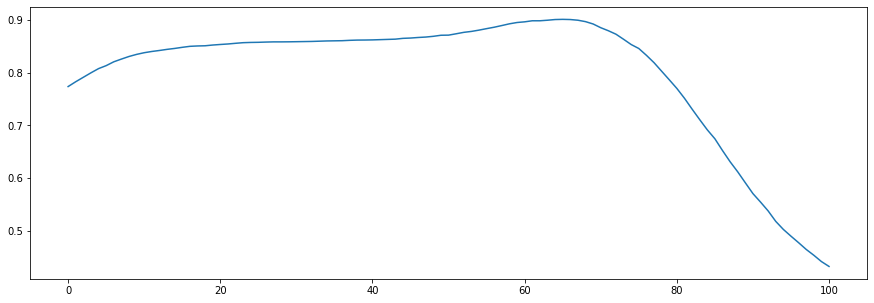

In [45]:
acc_list = list(acc_vals.values())
plt.plot(range(len(acc_list)), acc_list)
max_key = max(acc_vals, key=acc_vals.get)
print(max_key, acc_vals[max_key])

The maximum value for the accuracy is obtained by setting the threshold to 0.65, the value we picked manually, reusing the value we used for dividing the customers.

This seems coherent with what could be expected: if we discretized by using this threshold initially, the optimum now should be found at around this value. 

### 2.3.3) Random Forest Classifier

Now, let's go for our model: the random forest classifier:

**Using two categories**

Labels 1 and 0:

In [46]:
rfc_model = RandomForestClassifier()
fitted_rfc_model = rfc_model.fit(bi_x_train, bi_y_train)

print('Train\n')

y_train_hat = pd.Series(fitted_rfc_model.predict(bi_x_train))
_ = assesing_function(lambda x: x, y_train_hat, bi_y_train)

print('\nTest\n')

y_test_hat = pd.Series(fitted_rfc_model.predict(bi_x_test))
_ = assesing_function(lambda x: x, y_test_hat, bi_y_test)

Train

[[0.34937779 0.        ]
 [0.         0.65062221]]
1.0

Test

[[0.34018077 0.01780334]
 [0.01561216 0.62640373]]
0.9665844973979731


We can see that we have obtained a train accuracy of 100% and a test accuracy of 96,65%.

There might be some modest overfitting.

Let's see if we can obtain some gains from our dubious customers by running the model with our full data.

**Using three categories**

Labels: 1, 0 and 0.5:

In [47]:
rfc_model = RandomForestClassifier()
fitted_rfc_model = rfc_model.fit(tri_x_train, 2*tri_y_train)

print('Train\n')

y_train_hat = pd.Series(fitted_rfc_model.predict(tri_x_train))
rfc_cm, norm_rfc_cm, rfc_acc = assesing_function(lambda x: x, y_train_hat, 2*tri_y_train)

print('\nbinary results:\n')
_ = to_binary(norm_rfc_cm)

print('\nTest\n')

y_test_hat = pd.Series(fitted_rfc_model.predict(tri_x_test))
rfc_cm, norm_rfc_cm, rfc_acc = assesing_function(lambda x: x, y_test_hat, 2*tri_y_test)

print('\nbinary results:\n')
_ = to_binary(norm_rfc_cm)

Train

[[0.28582442 0.         0.        ]
 [0.         0.17808615 0.        ]
 [0.         0.         0.53608943]]
1.0

binary results:

[[0.34775472 0.         0.        ]
 [0.         0.         0.65224528]]
1.0

Test

[[0.2778777  0.00899281 0.00921763]
 [0.02225719 0.12207734 0.03732014]
 [0.00944245 0.01731115 0.4955036 ]]
0.8954586330935251

binary results:

[[0.33956044 0.01098901 0.01126374]
 [0.01153846 0.02115385 0.60549451]]
0.945054945054945


Again, we can see that we have obtained a train accuracy of 100% and a test accuracy of 94,5%, indicating that, for both cases, there might be some modest overfitting.

Also, we can see that for this model, keeping the clients with scores of 0.5 has resulted in no gains for our model.

We also want to point out the big improvement in accuracy for the full dataset results (almost 90% accuracy), when compared with the clustering models (70%) and the linear regression model (75%).

**Model tunning: hyperparameters optimization**

As we saw, there might be a little bit of overfitting for our vanilla model.

The default characteristics are:

In [48]:
fitted_rfc_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We are goint to tune three of the main characteristics of our algorithm:

* max_depth

* min_samples_split

* min_samples_leaf

In [49]:
max_depth = [2,3,4,5]
min_samples_split =[2,3,4,5]
min_samples_leaf = [1,2,3,4,5]

param_grid = {'max_depth':max_depth, 
              'min_samples_split':min_samples_split, 
              'min_samples_leaf': min_samples_leaf}

In [50]:
GS_rfc = GridSearchCV(estimator = fitted_rfc_model,
                     param_grid = param_grid,
                     cv = 5,
                     scoring = 'accuracy',
                     verbose = 0)

In [51]:
GS_rfc.fit(bi_x_train, bi_y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Let's see what are the best model accuracy and hyperparameters:

In [52]:
best_rfc = GS_rfc.best_estimator_
print(GS_rfc.best_score_)
print(GS_rfc.best_params_)

0.9571494242416725
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


And, finally, train it with our data for both the binary and ternary cases, and see the results:

In [53]:
rfc_model = best_rfc
fitted_rfc_model = rfc_model.fit(bi_x_train, bi_y_train)

print('Train\n')

y_train_hat = pd.Series(fitted_rfc_model.predict(bi_x_train))
_ = assesing_function(lambda x: x, y_train_hat, bi_y_train)

print('\nTest\n')

y_test_hat = pd.Series(fitted_rfc_model.predict(bi_x_test))
_ = assesing_function(lambda x: x, y_test_hat, bi_y_test)

Train

[[0.32695468 0.0224231 ]
 [0.01596619 0.63465602]]
0.961610706738671

Test

[[0.33470282 0.02328129]
 [0.01561216 0.62640373]]
0.9611065461517393


In [54]:
rfc_model = best_rfc
fitted_rfc_model = rfc_model.fit(tri_x_train, 2*tri_y_train)

print('Train\n')

y_train_hat = pd.Series(fitted_rfc_model.predict(tri_x_train))
rfc_cm, norm_rfc_cm, rfc_acc = assesing_function(lambda x: x, y_train_hat, 2*tri_y_train)

print('\nbinary results:\n')
_ = to_binary(norm_rfc_cm)

print('\nTest\n')

y_test_hat = pd.Series(fitted_rfc_model.predict(tri_x_test))
rfc_cm, norm_rfc_cm, rfc_acc = assesing_function(lambda x: x, y_test_hat, 2*tri_y_test)

print('\nbinary results:\n')
_ = to_binary(norm_rfc_cm)

Train

[[0.26481642 0.00414378 0.01686422]
 [0.02447721 0.08807941 0.06552954]
 [0.01349138 0.00848029 0.51411776]]
0.867013587742122

binary results:

[[0.32219486 0.00504162 0.02051823]
 [0.01641459 0.01031774 0.62551296]]
0.9477078203775353

Test

[[0.27338129 0.00314748 0.01955935]
 [0.03057554 0.08048561 0.07059353]
 [0.01236511 0.00696942 0.50292266]]
0.8567895683453237

binary results:

[[0.33406593 0.00384615 0.0239011 ]
 [0.01510989 0.00851648 0.61456044]]
0.9486263736263737


We can see that we have now more coherence between the train and test results, meaning a more stable behavior in our algorithm, a sympthom of no (or at least, less) overfitting.

This model obtains a 5% gain over the simple linear regression explored before (and about a 10% gain over the clustering algorithms).

Again, no differences have been obtained from keeping our dubious customers. In fact, in any case, keeping them makes our model learn worse.

This means that for training the model in production we should only keep our clients marked as 0 and 1, and drop the dubious.

# 3) General model

## 3.1) Setting the benchmark

**GENERAL BENCHMARK:**
    
As we did before, we will define the current success ratio rate as the following:

* $n_{or}$ = number of offers redeemed

* $n_{os}$ = number of offers sent


$SR = \frac{n_{or}}{n_{os}}$

The first benchmark for our model will be:

In [55]:
total_matched_offers['y'].sum()/total_matched_offers['y'].count()

0.6098381609368245

So, at this moment, the massive emailing campaign is getting a success probability of about 61%.

## 3.2) Normalization and feature engineering

 ### 2.2.1) Feature analysis

As we did with our customer data, let's treat now our offers data:

In [56]:
total_matched_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53201 entries, 0 to 53200
Data columns (total 17 columns):
id               53201 non-null object
offer_id         53201 non-null object
time_sent        53201 non-null int64
cust_offer_id    53201 non-null object
time_comp        53201 non-null float64
time_diff        32444 non-null float64
amount           53201 non-null float64
t_fr_lst_pur     53201 non-null float64
mean_am          53201 non-null float64
difficulty       53201 non-null int64
web              53201 non-null int64
email            53201 non-null int64
mobile           53201 non-null int64
social           53201 non-null int64
reward           53201 non-null int64
score            53201 non-null float64
y                53201 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 6.9+ MB


We can see that our *time_diff* column presents some missing values.

This was a design decission coming from the data manipulation. We kept this column as it was, because for modelling we will have to drop it (it has almost perfect correlation with our target variable, as only the offers that have been redeemed have a *time_diff* value, which is the time difference between reception and completion).

This is also the case for *time_comp* (time of completion for that offer) and *amount* (amount of the purchase of the completion).

We will drop also some other columns that contain text, but not numbers (*id*, *offer_id*, *cust_offer_id*).

And also _email_, because it has only one different value:

In [57]:
total_matched_offers['email'].unique()

array([1], dtype=int64)

...so it does not provide information of any kind.

So, dropping our columns, we have:

In [58]:
cols_to_drop = ['id', 'offer_id', 'cust_offer_id', # Text
                'time_comp', 'time_diff', 'amount', # Not known in the momment of sending the offer, would be almost perfectly
                                                    # correlated with y
                'email'] # Only one value: 1. No information
red_tot_matched_offers = total_matched_offers.drop(cols_to_drop, axis=1)
red_tot_matched_offers.head()

,time_sent,t_fr_lst_pur,mean_am,difficulty,web,mobile,social,reward,score,y
0,0,54.0,24.607500,10,1,1,1,2,1.0,1
1,0,204.0,5.090000,10,0,1,1,10,0.0,0
2,0,132.0,28.828000,5,1,1,0,5,1.0,1
3,0,12.0,25.008000,10,0,1,1,10,1.0,1
4,0,132.0,3.701765,10,1,1,0,2,0.5,1


Let's add a new feature, which is the inverse of the time from last purchase (seems reasonable to assume that the probability of someone using an offer goes with the inverse of the time of their last purchase, and not directly):

In [59]:
red_tot_matched_offers.insert(2,
                              'inv_t_fr_lst_pur', 
                              red_tot_matched_offers['t_fr_lst_pur'].apply(lambda x: 1/x if x!=0 else 1))

Finally, we can now check our correlations:

,time_sent,t_fr_lst_pur,inv_t_fr_lst_pur,mean_am,difficulty,web,mobile,social,reward,score,y
time_sent,1.000000,0.020940,0.068852,-0.025795,-0.005462,0.005246,0.003815,-0.000010,-0.000693,0.008077,-0.030990
t_fr_lst_pur,0.020940,1.000000,-0.246067,-0.132971,0.044337,0.021852,-0.058222,-0.088997,-0.021898,-0.338195,-0.445322
inv_t_fr_lst_pur,0.068852,-0.246067,1.000000,-0.005944,-0.019644,-0.003924,0.026294,0.044378,0.011127,0.105505,0.124605
mean_am,-0.025795,-0.132971,-0.005944,1.000000,0.001420,-0.006417,0.002105,0.007603,0.007467,0.294725,0.264848
difficulty,-0.005462,0.044337,-0.019644,0.001420,1.000000,-0.030382,-0.883877,-0.356739,0.063028,-0.032726,-0.092147
web,0.005246,0.021852,-0.003924,-0.006417,-0.030382,1.000000,-0.144193,-0.294676,-0.602862,0.010201,0.048665
mobile,0.003815,-0.058222,0.026294,0.002105,-0.883877,-0.144193,1.000000,0.489327,0.031647,0.031239,0.082996
social,-0.000010,-0.088997,0.044378,0.007603,-0.356739,-0.294676,0.489327,1.000000,0.322984,0.025993,0.058639
reward,-0.000693,-0.021898,0.011127,0.007467,0.063028,-0.602862,0.031647,0.322984,1.000000,-0.035267,-0.125660
score,0.008077,-0.338195,0.105505,0.294725,-0.032726,0.010201,0.031239,0.025993,-0.035267,1.000000,0.715047


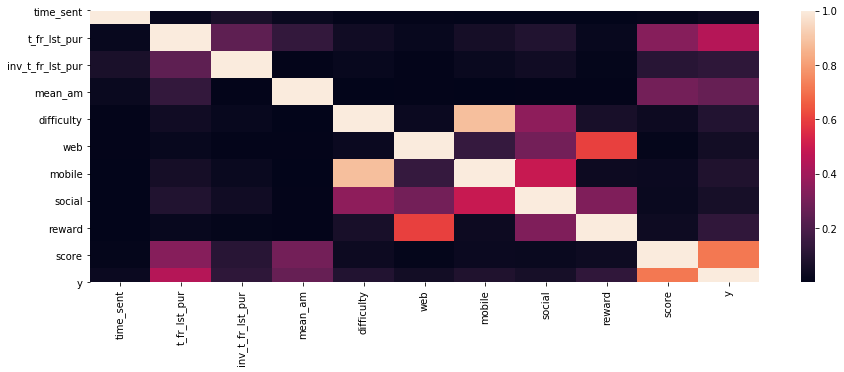

In [60]:
mo_corrs = red_tot_matched_offers.corr()
sns.heatmap(abs(mo_corrs))
mo_corrs

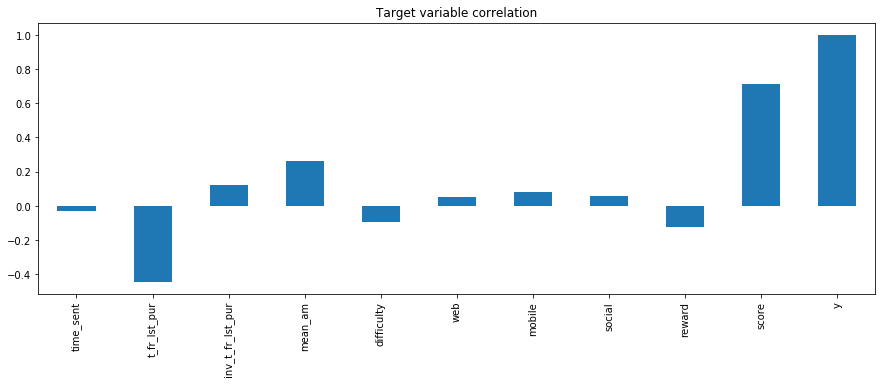

In [61]:
mo_corrs['y'].plot('bar', title='Target variable correlation');

We can see that our assumption was wrong, and seems that the probability of completion of an offer is directly (although with negative correlation), and not inversely related to the time of last purchase.

In any case, we will preserve the column, in case it can provide some insight to our models.

We can also see that some of our variables are slightly correlated with each other, but it doesn't a problem.

### 3.2.2) Normalization

As we did previously, we nor normalize our data using MinMaxScaler.

In this case, we do not have two diferent sets of data: offers are only fulfilled (1) or they are not (0):

In [62]:
scaled_xy = pd.DataFrame(MinMaxScaler().fit(red_tot_matched_offers).transform(red_tot_matched_offers), 
                         columns = red_tot_matched_offers.columns)

xy_train, xy_test = train_test_split(scaled_xy, random_state=37, train_size=0.7)

x_train = xy_train.drop('y', axis=1)
y_train = xy_train['y']

x_test = xy_test.drop('y', axis=1)
y_test = xy_test['y']

## 3.3) Models

### 3.3.1) Benchmark model

As benchmark model, we will use a simple linear regression:

In [63]:
lr = LinearRegression()
lr_fitted = lr.fit(x_train, y_train)

print('Train\n')

y_train_hat = pd.Series(lr_fitted.predict(x_train)).apply(lambda x: 1 if x>0.65 else 0)
_ = assesing_function(lambda x: x, y_train_hat, y_train)

print('\nTest\n')

y_test_hat = pd.Series(lr_fitted.predict(x_test)).apply(lambda x: 1 if x>0.65 else 0)
_ = assesing_function(lambda x: x, y_test_hat, y_test)

Train

[[0.34411923 0.04656284]
 [0.10107411 0.50824382]]
0.8523630504833513

Test

[[0.34565503 0.04329303]
 [0.09905394 0.511998  ]]
0.8576530292588185


We can see that our behavior is consistent, and there is no signal of overfitting.

Let's look at which features are the most important in determining our target variable:

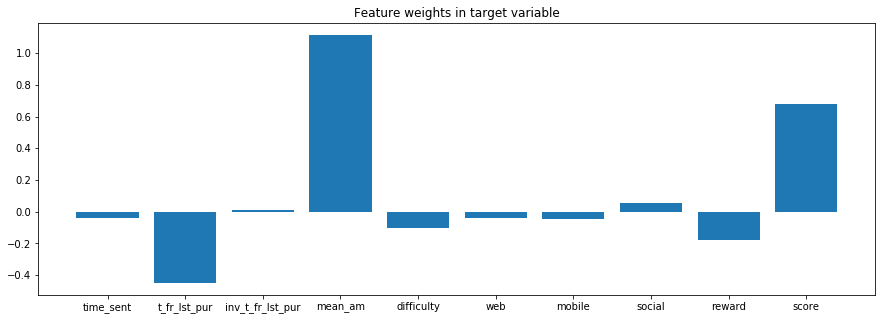

In [64]:
plt.bar(x_train.columns, lr_fitted.coef_)
plt.title('Feature weights in target variable');

It seems that the time from last purchase, the mean ammount the client has spent up to the moment of the offer, the reward and the client's score (0, 0.5 or 1) are the most importan features, determining the success of an offer.

On the other hand, the medium selected for the offer seems to be of no importance.

### 3.3.2) Model behavior comparison

Now, let's run a series of models in order to select our horse.

This time we will use a cross validation to be more sure of our selection:

In [65]:
models = {'MultinomialNB': MultinomialNB(), 
          'BernoulliNB': BernoulliNB(), 
          'GaussianNB': GaussianNB(), 
          'LogisticRegression': LogisticRegression(),
          'SVC': SVC(),
          'SGDClassifier': SGDClassifier(), 
          'RandomForestClassifier': RandomForestClassifier()}

model_acc_dict = dict([])

for model_name, model in models.items():
    
    cv = cross_validate(estimator=model, 
                        X=scaled_xy.drop('y', axis=1), 
                        y=scaled_xy['y'].astype('int'), 
                        scoring='accuracy')
    
    model_acc_dict[model_name] = cv['test_score'].mean()
    
model_acc_dict

{'MultinomialNB': 0.8234435238787693,
 'BernoulliNB': 0.8548905337066941,
 'GaussianNB': 0.8699276171822282,
 'LogisticRegression': 0.8800214961565176,
 'SVC': 0.8778974006767696,
 'SGDClassifier': 0.8777659330169236,
 'RandomForestClassifier': 0.9005661125607931}

Again, the RandomForestClassifier seems to be the most promising.

### 3.3.3) Random forest classifier

**Untunned model**

Let's see the behavior of the vanilla model:

In [66]:
rfg = RandomForestClassifier()
rfg_fitted = rfg.fit(x_train, y_train)

print('Train\n')

y_train_hat = pd.Series(rfg_fitted.predict(x_train))
_ = assesing_function(lambda x: x, y_train_hat, y_train)

print('\nTest\n')

y_test_hat = pd.Series(rfg_fitted.predict(x_test))
_ = assesing_function(lambda x: x, y_test_hat, y_test)

Train

[[3.90682062e-01 0.00000000e+00]
 [8.05585392e-05 6.09237379e-01]]
0.9999194414607948

Test

[[0.34220913 0.04673893]
 [0.04774137 0.56331057]]
0.9055197042791805


As it happened to us before in the customer case, the difference in accuracy obtained between the train and test scenarios signals a certain ammount of overfitting.

So, as we did before, we are going to tune our model, to make it more stable:

**Model tunning: hyperparameters optimization**

In [67]:
GS_rfg = GridSearchCV(estimator = RandomForestClassifier(),
                     param_grid = param_grid,
                     cv = 5,
                     scoring = 'accuracy',
                     verbose = 0)

GS_rfg.fit(scaled_xy.drop('y', axis=1), scaled_xy['y'].astype('int'))

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

Let's see the best model result and parameters:

In [68]:
best_rfg = GS_rfg.best_estimator_
print(GS_rfg.best_score_)
print(GS_rfg.best_params_)

0.9025209202877505
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


...and, finally, let's train it and comment its results:

In [69]:
rfg_model = best_rfg
fitted_rfg_model = rfg_model.fit(bi_x_train, bi_y_train)

print('Train\n')

y_train_hat = pd.Series(fitted_rfg_model.predict(bi_x_train))
_ = assesing_function(lambda x: x, y_train_hat, bi_y_train)

print('\nTest\n')

y_test_hat = pd.Series(fitted_rfg_model.predict(bi_x_test))
_ = assesing_function(lambda x: x, y_test_hat, bi_y_test)

Train

[[0.32531111 0.02406668]
 [0.0147922  0.63583001]]
0.9611411129373093

Test

[[0.33251164 0.02547247]
 [0.01533826 0.62667762]]
0.9591892632155574


We can see that we have obtained accuracies of about 96% for both the train and test scenarios.

This also reveals that the overfitting should be corrected.

Again, note that this result is better than the one obtained in the benchmark model, which, in its turn, is also better than the general benchmark.

# 4) Conclussions

## 4.1) Summing up

Along this script we have created two models: one model for determining which customers are receptive to our offers, and another one for predicting if a particular offer is going to be succesful.

In order to do so, we have inspected our data, normalized it, and then, run simple model to use it as benchmark, and later, run a battery of models, selected the most promising and we have tuned it in order to perfect its behavior, specially in terms of possible overfitting.

For both cases, the model of our election has been a random forest classifier.

## 4.2) Customer characterization

The general benchmark for this model was about 53% (that meant, considering all clients were susceptible to our offers).

In the case of our customer characterization, we have also run some clustering algorithms that allowed us to get some insight in which of our customers are more prone to redeem our offers, and create a persona for those clients.

As we have seen, we have been able also to use those clusters to create a minimodel over them, that yielded about 70% (considering all clients) or 85% (when dropping the dubious) accuracy, both when using DBSCAN and KMeans algorithms for such clustering.

This already meant a significant improvement from our current situation.

But we could do better: a simple linear regression yielded results of 75% and 90%.

And, finally, a tuned random forest classifier took us to results of 80% and 95% in terms of accuracy.

## 4.3) Offers model

For our general model, we started from a general benchmark of 61% (considering the previous success rate).

A simple linear regression took that accuracy up to the 85% range, and also showed us that the most important features when determining the success of an offer were:
    
* the time past from that client's last purchase

* the mean ammount the client has spent up to the moment of the offer

* the offer reward

* the client's score (0, 0.5 or 1)

Again, after running a battery of models, we selected a random forest classifier as the model of our choice. That model, after fine tunning, got the accuracy up to 96%.

## 4.4) Possible further improvements

There are certain features we could create both for the customers and offers datasets, and feed our models.

Also, dimensionality reduction via PCA, or just by keeping the most prominent features, was not performed.

Finally, the author has the concern of how would impact the results, if, instead of considering the client behaviour as discrete (0 and 1, with 0.5 as mark for 'dubious'), a continuous variable was used instead. This could take the prediction on the offers model beyond. Nevertheless, it would mean that the metrics for assessing the customers models employed would become less intuitive (which was the reason for the discrete approach in the first place).

## 4.5 Final considerations

Along this project we have tried to perfectionate the offer campaigns of a coffee retailer.

Starting from the information on three files:
    
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

we have cleaned and treat that information, and used it to feed two models:

* a first model that tells us whether a client is interested in our offers or not

* a second model that tells us whether a particular offer will be successful

Our models have obtained accuracies in the 95-96% range, when using a random forest classifier.

For this particular problem, as the failures should not be very harmful, this means almost pinpointing our offers and our interested customers.

What is best, it improves our current situation dramatically.

In my opinion, this project reveals the true power of machine learning algorithms for dealing with certain kind of problems, and the reason for their present date popularity.